In [1]:
import pandas as pd 
import numpy as np
import math
import itertools
from itertools import compress
import geopandas as gpd
import pickle
import xgboost as xgb
import polars
import os
from glob import glob
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import math

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import polars
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score, roc_auc_score


import sys
import os

sys.path.append('scripts')

In [2]:
kdprov = '32'

In [3]:
# Parameters
kdprov = 35


In [4]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [5]:
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/fulldataset_VH.pkl', 'rb') as file:
    dt_full=pickle.load(file).to_pandas()

In [6]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl', 'rb') as file:
    xg_dt=pickle.load(file)

In [7]:
cluster=np.sort(dt_full.cluster_data.unique())

In [8]:
dict_predict={}
for cl in cluster:
    print('Predicting for cluster:',cl)
    start_time = time()
    dt_cl=dt_full.query('cluster_data==@cl')
    y = dt_cl.observation
    X = dt_cl.loc[:,'VH_30':'VH_0']
    X['nth'] = dt_cl.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    model=xg_dt[cl]['model']
    dtest = xgb.DMatrix(X, enable_categorical=True)
    y_pred_prob=model.predict(dtest)
    y_pred=y_pred_prob.argmax(axis=1)
    dt_pred=dt_cl[['idpoint', 'idsubsegment', 'idsegment','periode', 'observation','idkabkota', 'cluster_data']]
    dt_pred['prediction']=y_pred
    score={}
    score['accuracy']=accuracy_score(y, y_pred)
    score['f1_macro']=f1_score(y, y_pred, average='macro')
    score['f1_micro']=f1_score(y, y_pred, average='micro')
    score['auc']=roc_auc_score(y,y_pred_prob, multi_class='ovr')
    score['acc_generative']=akurasi_kelas_generatif(y, y_pred)
    score['acc_fase_padi']=akurasi_fase_padi(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    score['relative_acc']=relative_acc
    print(score)
    print(cm)
    end_time = time()
    elapsed_time = end_time - start_time
    print('Finish with processed time:',elapsed_time)
    dict_predict[cl]={'data_prediction':dt_pred,
                        'score':score,
                    'time':elapsed_time}

Predicting for cluster: 0


{'accuracy': 0.5009631527268164, 'f1_macro': np.float64(0.39451202769885013), 'f1_micro': np.float64(0.5009631527268164), 'auc': np.float64(0.7802467502134737), 'acc_generative': 0.4044132222403747, 'acc_fase_padi': 0.3201567424823239, 'relative_acc': np.float64(88.49819257311863)}
[[  76315   10825    3516    6225   11555   48651  175438]
 [  13720  112906   21729    5915    6549  120202   96104]
 [  15740   34993   99374   32699    5165   42876  100478]
 [  15083    3151   30302  185656   33671   47577  143635]
 [  18106    8068     734   29541   71854   67955  103592]
 [   6089   14098    1090    2425    6804   88845   37774]
 [  80042   27655   16646   37692   26855  178911 1061449]]
Finish with processed time: 58.221627950668335
Predicting for cluster: 1


{'accuracy': 0.40330336965801233, 'f1_macro': np.float64(0.3727455682346457), 'f1_micro': np.float64(0.40330336965801233), 'auc': np.float64(0.7606919096277897), 'acc_generative': 0.40849432929213925, 'acc_fase_padi': 0.38907100199071004, 'relative_acc': np.float64(84.09275708633511)}
[[ 24095   5510   3485   3979  20368  40314  48474]
 [  1959  41768  10450   4593  10965  40489  17376]
 [   762   9716  29345  15524   9240  17546  13542]
 [   946   2888   8563  52226  29476  15951  17800]
 [  3995   2726   1652   7408  52560  16794  15840]
 [  2564   4732    741    800   4073  31607   5383]
 [  9953  12382  10166  18960  45385  80631 169948]]
Finish with processed time: 11.54637336730957
Predicting for cluster: 2


{'accuracy': 0.5355975827661668, 'f1_macro': np.float64(0.37154727879583843), 'f1_micro': np.float64(0.5355975827661668), 'auc': np.float64(0.7627627116725725), 'acc_generative': 0.34192777169795435, 'acc_fase_padi': 0.2978523453134852, 'relative_acc': np.float64(90.47336476743399)}
[[ 40135   2067   1025   1703   1729   9211  27830]
 [ 18431  70587  15459   3891   3351  58793  81113]
 [ 12134  16746  71738  14611   1166  12675  86955]
 [ 13235   3337  21987 101544  12640  20776 123456]
 [ 13736   4454   1119  14624  27750  25527  60090]
 [  8053   6619    819   1873   4484  44604  29048]
 [176876  28184  25735  39890  18687 132432 977521]]
Finish with processed time: 25.902143001556396
Predicting for cluster: 3


{'accuracy': 0.47838659469483724, 'f1_macro': np.float64(0.43711763208179955), 'f1_micro': np.float64(0.47838659469483724), 'auc': np.float64(0.8136233540390897), 'acc_generative': 0.5764217156568686, 'acc_fase_padi': 0.5536786459540923, 'relative_acc': np.float64(93.83022193438691)}
[[ 20250   5755   2799   3028   3276   5912   6330]
 [ 32338 152996  23815   3221   7002  41093  18485]
 [ 26914  26876 148597  21942   1651  11299  18446]
 [ 34133   5025  30411 192179  26949  19080  25623]
 [ 22888   7439   2247  18086 103232  42101  14182]
 [  6253  10294    401   1129  18058  32950   4090]
 [ 87250  30335  24250  30912  20733  45507  72088]]
Finish with processed time: 20.11539912223816
Predicting for cluster: 4


{'accuracy': 0.5192878645343367, 'f1_macro': np.float64(0.4293953083403382), 'f1_micro': np.float64(0.5192878645343367), 'auc': np.float64(0.7790593274338136), 'acc_generative': 0.45488864997696205, 'acc_fase_padi': 0.4087230400547758, 'relative_acc': np.float64(93.98693281715373)}
[[ 29099   4082   2135   2430   2463   7576  35040]
 [ 20306 110860  19216   3856   6958  31962  73467]
 [ 17776  21484  98602  25203    985   5663  74012]
 [ 15559   2481  24989 148089  22322  15223  96887]
 [ 14816   4069   1164  16104  60307  31409  58581]
 [  8991  11226   1123   1844  11071  44986  25634]
 [122398  28523  25883  36628  21040  69415 612063]]
Finish with processed time: 25.368499040603638
Predicting for cluster: 5


{'accuracy': 0.43496542095522583, 'f1_macro': np.float64(0.24231617007353087), 'f1_micro': np.float64(0.43496542095522583), 'auc': np.float64(0.6788018059700219), 'acc_generative': 0.10871912518161658, 'acc_fase_padi': 0.19714455681142176, 'relative_acc': np.float64(74.61663898987179)}
[[  20889    1693    2080    1083    9839    8506   25560]
 [  30365   39610   28749    4921   44766   52945   96169]
 [  21726   13374   58274    7256   37450   29422   82348]
 [  27595    6847   31861   35543   90879   33285  100915]
 [  18454    3392    5516    5730   73698   22401   47134]
 [   8789    3466    2688    1383   13417   21557   23450]
 [ 209224   31709   62136   23957  256683  211087 1090079]]
Finish with processed time: 32.89032769203186
Predicting for cluster: 6


{'accuracy': 0.5148573863232893, 'f1_macro': np.float64(0.3398415653692912), 'f1_micro': np.float64(0.5148573863232893), 'auc': np.float64(0.7385131731684969), 'acc_generative': 0.19752014324082365, 'acc_fase_padi': 0.2896355106459762, 'relative_acc': np.float64(90.8043172728448)}
[[ 31030   2122   1858   1156  10424  10497  27863]
 [ 16510  51897  30362   2393   8247  29769  67022]
 [  7552  17389  52476   7227   6551   6422  43608]
 [ 10768   3881  35455  44126  44990   7167  77013]
 [ 13112   1063   3357   6317  52146   8125  37805]
 [ 16801   8397   3967   1051  12527  34260  39797]
 [114709  26450  68792  18576  92302  75397 821624]]
Finish with processed time: 41.79549217224121
Predicting for cluster: 7


{'accuracy': 0.5035330728415458, 'f1_macro': np.float64(0.3715749020897617), 'f1_micro': np.float64(0.5035330728415458), 'auc': np.float64(0.7413005507427682), 'acc_generative': 0.3383440766005382, 'acc_fase_padi': 0.3359288258939628, 'relative_acc': np.float64(87.83128442103417)}
[[ 27996   4852   2433   2121   5524   9500  24249]
 [ 32097 118074  30926  10398   9926  46433  98196]
 [ 20686  35464 116591  21304   4369  21311  97150]
 [ 29127  10290  45216 135160  21493  28723 129466]
 [ 28139   8201   6123  27576  71006  31757  77073]
 [ 15548  11301   2708   3390  11116  37620  31367]
 [126412  48844  50536  46950  35195 116393 933645]]
Finish with processed time: 30.961036443710327
Predicting for cluster: 8


{'accuracy': 0.5301043154746611, 'f1_macro': np.float64(0.40999701183434256), 'f1_micro': np.float64(0.5301043154746611), 'auc': np.float64(0.7966860012528793), 'acc_generative': 0.2910907741775909, 'acc_fase_padi': 0.3740161883738043, 'relative_acc': np.float64(95.21917800518314)}
[[145389   3476  15495   2331  13582  42209 216643]
 [  5045  34625  38909    659   5177  56137  25198]
 [  3542   8492 102995   6798    405   4536  17007]
 [  5344    247  63954  58844   9842   4426  59493]
 [ 10155    939   6534  10906  57680  10768  70843]
 [  5081   2438   2280    310   2161  43591  17589]
 [105483   7988 102596  12162  20599 145254 846368]]
Finish with processed time: 24.75044322013855


In [9]:
pivot_kabkota=[]
cm_prediction={}
df_for_estimation=[]
for cl in cluster:
    print('Running for cluster:',cl)
    df_pred=dict_predict[cl]['data_prediction']
    df_pred_dom=df_pred.groupby(['idsubsegment', 'idkabkota','periode'])['prediction'].agg(lambda x: x.mode()[0]).reset_index()
    df_pred_obs=df_pred.groupby(['idsubsegment', 'idkabkota','periode'])['observation'].agg(lambda x: x.mode()[0]).reset_index()
    df_pred_dom_obs=df_pred_dom.merge(df_pred_obs).rename(columns={'prediction':'dom_pred'})
    df_pred['idpoint_loc']=df_pred.idpoint.apply(lambda y:y.split('#')[1])
    df_pred_center=df_pred.query('idpoint_loc=="13"')[['idsubsegment', 'idkabkota','periode','prediction']]
    df_pred_center_obs=df_pred_center.merge(df_pred_obs).rename(columns={'prediction':'center_pred'})
    df_pred_subsegment=df_pred_center_obs.merge(df_pred_dom_obs)
    df_for_estimation.append(df_pred_subsegment)
    for idkab in df_pred.idkabkota.unique():
        #print('Get Metrics for Each Point Prediction')
        score={}
        score['idkabkota']=[idkab]
        y=df_pred.query('idkabkota==@idkab')['observation']
        y_pred=df_pred.query('idkabkota==@idkab')['prediction']
        score['accuracy_titik']=[accuracy_score(y, y_pred)]
        score['f1_macro_titik']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_titik']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_titik']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_titik']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_titik']=[relative_acc]
        cm_titik=cm
        
        y=df_pred_dom_obs.query('idkabkota==@idkab')['observation']
        y_pred=df_pred_dom_obs.query('idkabkota==@idkab')['dom_pred']
        
        #print('Get Metrics for Dominant Prediction')
        score['accuracy_dom']=[accuracy_score(y, y_pred)]
        score['f1_macro_dom']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_dom']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_dom']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_dom']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_dom']=[relative_acc]
        cm_dom=cm
        
        #print('Get Metrics for Center Point Prediction')
        y=df_pred_center_obs.query('idkabkota==@idkab')['observation']
        y_pred=df_pred_center_obs.query('idkabkota==@idkab')['center_pred']
        score['accuracy_center']=[accuracy_score(y, y_pred)]
        score['f1_macro_center']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_center']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_center']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_center']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_center']=[relative_acc]
        cm_center=cm
        cm_prediction[idkab]={'point':cm_titik,'dominant':cm_dom,'center':cm_center}
        pivotal_df=pd.DataFrame(score)
        pivot_kabkota.append(pivotal_df)
        #df_for_estimation.append()
pivot_kabkota=pd.concat(pivot_kabkota)
df_for_estimation=pd.concat(df_for_estimation)

Running for cluster: 0


Running for cluster: 1


Running for cluster: 2


Running for cluster: 3


Running for cluster: 4


Running for cluster: 5


Running for cluster: 6


Running for cluster: 7


Running for cluster: 8


In [10]:
with open(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_pivot_cm.pkl', 'wb') as file:
    pickle.dump({'pivot':pivot_kabkota,'cm':cm_prediction,'df_for_est':df_for_estimation},file)

In [11]:
dict_date={
    '2022_03':'2022_01',
    '2022_05':'2022_02',
    '2022_08':'2022_03',
    '2022_10':'2022_04',
    '2022_13':'2022_05',
    '2022_15':'2022_06',
    '2022_18':'2022_07',
    '2022_20':'2022_08',
    '2022_23':'2022_09',
    '2022_25':'2022_10',
    '2022_28':'2022_11',
    '2022_30':'2022_12',
    '2023_03':'2023_01',
    '2023_05':'2023_02',
    '2023_08':'2023_03',
    '2023_10':'2023_04',
    '2023_13':'2023_05',
    '2023_15':'2023_06',
    '2023_18':'2023_07',
    '2023_20':'2023_08',
    '2023_23':'2023_09',
    '2023_25':'2023_10',
    '2023_28':'2023_11',
    '2023_30':'2023_12'
}

In [12]:
df_for_estimation['periode']=df_for_estimation.periode.apply(lambda y:dict_date[y])

In [13]:
df_for_estimation.to_csv(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_forestimation.csv',sep=';')

In [14]:
cm_period={}
acc_fase_period={}
for i in df_for_estimation.periode.unique():
    df_x=df_for_estimation.query('periode==@i')
    y_true=df_x['observation']
    y_pred_center=df_x['center_pred']
    y_pred_dom=df_x['dom_pred']
    cm_center = confusion_matrix(y_true, y_pred_center)
    cm_dom = confusion_matrix(y_true, y_pred_dom)
    cm_center= cm_center.astype('float') / cm_center.sum(axis=1, keepdims=True) * 100
    cm_dom= cm_dom.astype('float') / cm_dom.sum(axis=1, keepdims=True) * 100
    cm=cm_center
    relative_acc_center = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    cm=cm_dom
    relative_acc_dom = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    
    cm_period[i]={'center':cm_center,'dom':cm_dom}
    acc_center=[]
    acc_dom=[]
    for j in range(7):
        acc_center.append(cm_center[j,j])
        acc_dom.append(cm_dom[j,j])
    acc_center.append(accuracy_score(y_true, y_pred_center))
    acc_dom.append(accuracy_score(y_true, y_pred_dom))
    acc_center.append(akurasi_fase_padi(y_true, y_pred_center))
    acc_dom.append(akurasi_fase_padi(y_true, y_pred_dom))
    acc_center.append(relative_acc_center)
    acc_dom.append(relative_acc_dom)
    acc_fase_period[i]={'center':acc_center,'dom':acc_dom}

In [15]:
acc_fase_data=pd.DataFrame(acc_fase_period).T.reset_index()
acc_fase_data['center']=acc_fase_data.center.apply(lambda y: np.array(y))
acc_fase_data['dom']=acc_fase_data.dom.apply(lambda y: np.array(y))

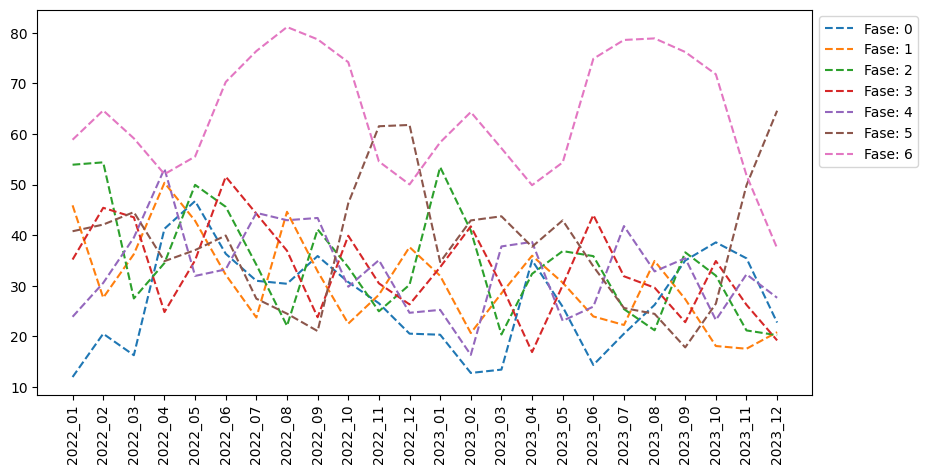

In [16]:
fase0=[]
fase1=[]
fase2=[]
fase3=[]
fase4=[]
fase5=[]
fase6=[]
for i in range(acc_fase_data.shape[0]):
    fase0.append(acc_fase_data['center'][i][0])
    fase1.append(acc_fase_data['center'][i][1])
    fase2.append(acc_fase_data['center'][i][2])
    fase3.append(acc_fase_data['center'][i][3])
    fase4.append(acc_fase_data['center'][i][4])
    fase5.append(acc_fase_data['center'][i][5])
    fase6.append(acc_fase_data['center'][i][6])
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, fase0, linestyle='--', label='Fase: 0', color='tab:blue')
plt.plot(x, fase1, linestyle='--', label='Fase: 1', color='tab:orange')
plt.plot(x, fase2, linestyle='--', label='Fase: 2', color='tab:green')
plt.plot(x, fase3, linestyle='--', label='Fase: 3', color='tab:red')
plt.plot(x, fase4, linestyle='--', label='Fase: 4', color='tab:purple')
plt.plot(x, fase5, linestyle='--', label='Fase: 5', color='tab:brown')
plt.plot(x, fase6, linestyle='--', label='Fase: 6', color='tab:pink')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

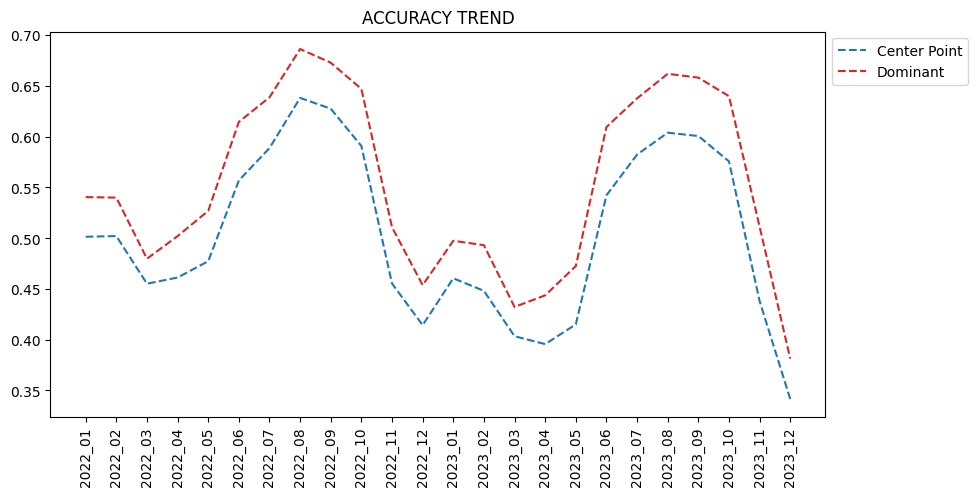

In [17]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][7])
    acc_dom.append(acc_fase_data['dom'][i][7])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('ACCURACY TREND')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_acc_tred.png', dpi=300, bbox_inches='tight')
plt.show()

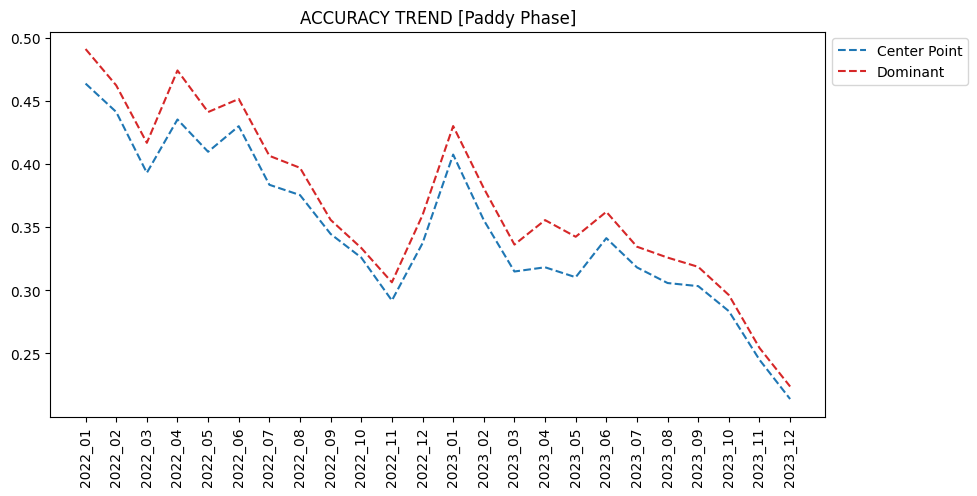

In [18]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][8])
    acc_dom.append(acc_fase_data['dom'][i][8])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('ACCURACY TREND [Paddy Phase]')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_acc_paddy_tred.png', dpi=300, bbox_inches='tight')
plt.show()

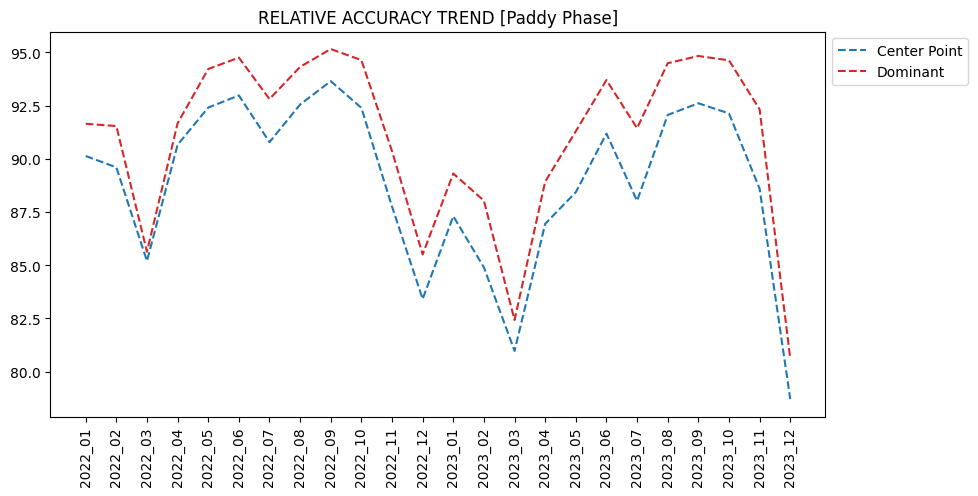

In [19]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][9])
    acc_dom.append(acc_fase_data['dom'][i][9])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('RELATIVE ACCURACY TREND [Paddy Phase]')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_relacc_tred.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
df_for_estimation['periode']=df_for_estimation.periode.apply(lambda y:y.replace('_',''))
df_for_estimation['id_segmen']=df_for_estimation.idsubsegment.apply(lambda y:y[:9])
df_for_estimation['subsegmen']=df_for_estimation.idsubsegment.apply(lambda y:y[9:])
df_for_estimation['tahun']=df_for_estimation.periode.apply(lambda y: y[:4])
df_for_estimation['bulan']=df_for_estimation.periode.apply(lambda y: y[4:])
df_for_estimation['fase_obs']=df_for_estimation.observation
df_for_estimation['fase_pred']=df_for_estimation.center_pred
df_for_estimation['fase_dom']=df_for_estimation.dom_pred
df_for_estimation.to_csv(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_forestimation.csv',sep=';')